In [1]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
from obspy import UTCDateTime
import sys
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import matplotlib.pyplot as plt
import matplotlib
import os

In [2]:
def preprocessing(year,jday, net, sta, cha):

    try:
        # this stream will be used for RSAM and DSAR calculations
        #st = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st = client.get_waveforms(network=net, station=sta, channel=cha,
                                       year='{}'.format(year), doy='{}'.format(jday))

#         st.detrend('demean')
#         st.taper(0.05, type='hann')
#         st.merge(fill_value=0)
        
#         # correct insrument response
#         inv = obspy.read_inventory('/auto/pnwstore1-wd11/PNWStationXML/{}/{}.{}.xml'.format(net,net,sta))
#         pre_filt = [1e-3, 5e-2, 45, 50]
#         water_level = 60
        
#         for tr in st:
#             tr.remove_response(inventory=inv, zero_mean=True,taper=True, taper_fraction=0.05,
#                                       pre_filt=pre_filt, output="VEL", water_level=water_level,
#                                       plot=False)

#             # correct positive dip
#             dip = inv.get_orientation(tr.id, datetime=tr.stats.starttime)['dip']
#             if dip > 0:
#                 tr.data *= -1
        
    except:
        print('pass {}'.format(jday))
    return(st)

In [176]:
def read_stream(net, stn, chn, year, jday):
    st = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network='{}'.format(net), station='{}'.format(stn), channel='{}'.format(chn),
                                       year='{}'.format(year), doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        #st.taper(0.45) # find a good value!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
    except:
        print('pass {}'.format(jday))
    return(st)

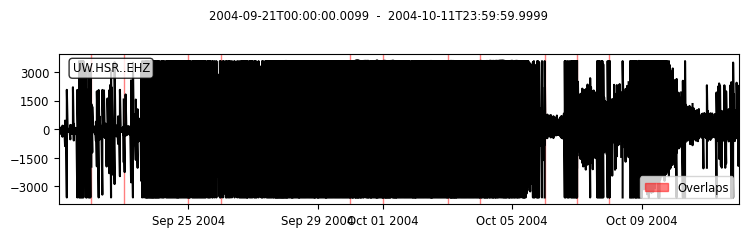

409 Trace(s) in Stream:

UW.HSR..EHZ | 2004-09-21T00:00:00.009900Z - 2004-09-21T23:59:59.999900Z | 100.0 Hz, 8640000 samples
...
(407 other traces)
...
UW.HSR..EHZ | 2004-10-11T00:13:44.169900Z - 2004-10-11T23:59:59.999900Z | 100.0 Hz, 8557584 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [3]:
net = 'UW'
sta = 'HSR'
cha = 'EHZ'
year = 2004
jdays = range(265,285+1)
#jdays = range(267,287+1)
#jdays = ['162', '161']
st = obspy.Stream()
for jday in jdays:
    st_read = preprocessing(year,jday, net, sta, cha)
    st += st_read
st.plot()
st

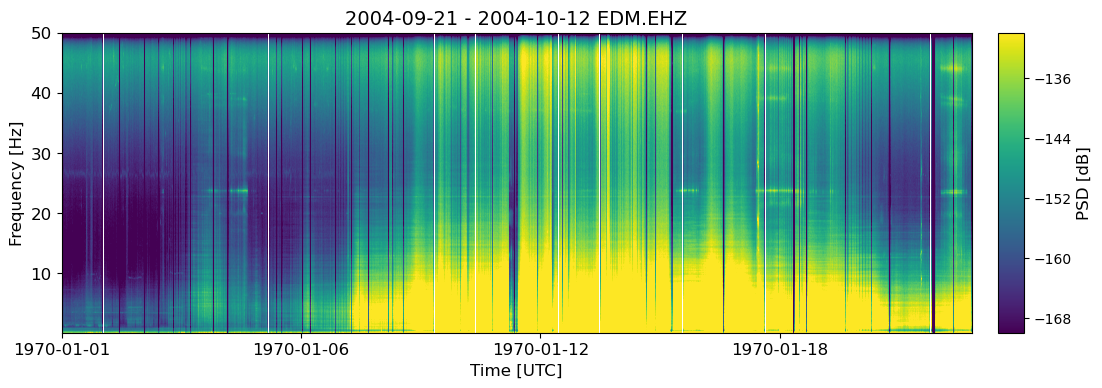

In [28]:

# frequenc filter
#fmin = 19
#fmax = 41
#st.filter('bandpass', freqmin=fmin, freqmax=fmax)
st = st.merge()
tr = st[0] #only get one obspy trace from obspy stream
s_date = tr.stats.starttime.date
e_date = tr.stats.endtime.date
data = tr.data #extract numpy data array from obspy trace

data = data/1. #extract numpy data array from obspy trace and convert to float   
# if len(loc) !=0:  
#     index = stn+'.'+loc
# else:
#     index = stn

# convert data from counts to velocity
# data = data / df_sens.loc[index][0] #V/(m/s) sensitivity
# data = data / df_sens.loc[index][1] #cnts/V


fs = tr.stats.sampling_rate #sampling rate

NFFT = fs * 10 #bin size for fourier transform. Type in length in seconds [for a day 100, for an hour 10]

fig = plt.figure(figsize=(13,5)) #create figure and add axes to it 13,5 od 10,5
ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.60]) #[left bottom width height]
ax2 = fig.add_axes([0.82, 0.1, 0.02, 0.6])

#plot spectrogram on first axis
Pxx, freqs, bins, im = ax1.specgram(data, NFFT=int(NFFT), Fs=fs, 
                                    noverlap=fs*0, #overlap of bins in samples
                                    detrend='linear', #detrending before taking fourier transform
                                    mode='psd', #'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True, #unit/Hz
                                    scale='dB', #'linear', 'dB'
                                    cmap='viridis', #your favourite colormap
                                    vmin=-170, #-25
                                    vmax=-130#, #50
#                                     xextent=[tr.stats.starttime.timestamp, 
#                                              tr.stats.endtime.timestamp]
                                   )

#show the date and time in the x-ticks
my_times = [(tr.stats.starttime + i).timestamp for i in bins]
def timeTicks(my_times, pos):                                                                                                                                                                                                                                                         
    return datetime.datetime.utcfromtimestamp(my_times).strftime("%Y-%m-%d") # %Y-%m-%d:%H:%M:%S                                                                                                                                                                                                                                                                                
formatter = matplotlib.ticker.FuncFormatter(timeTicks)   
ax1.xaxis.set_major_formatter(formatter) 
#ax1.tick_params(axis='x', rotation=45)
ax1.locator_params(axis='x', nbins=7)

#ax1.set_yscale('log') #uncomment for logarithmic y-scale
ax1.set_title('{} - {} {}.{}'.format(s_date,e_date,stn,chn), fontsize=14)
ax1.set_xlabel('Time [UTC]', fontsize=12) #x-label 
ax1.set_ylabel('Frequency [Hz]', fontsize=12) #y-label
ax1.tick_params(axis='both', labelsize=12) 
ax1.set_ylim([0.1,50]) #be carefull with lower limit when y-scale is logarithmic

cbar = plt.colorbar(im, cax=ax2) #map colorbar to image (output of specgram), plot it on ax2
cbar.set_label('PSD [dB]', fontsize=12) #colorbar label   Intensity
cbar.locator = matplotlib.ticker.MaxNLocator(nbins=6) # amount of ticks of the colorbar (Anzahl beschriftungen des colbar)
cbar.update_ticks()

# save_dir = 'test_{}'.format(day)
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

#plt.savefig(save_dir+'/{}.{}_{}.png'.format(stn,loc,chn),bbox_inches='tight', dpi=300) # RA9x
#plt.savefig(save_dir+'/neu_{}_{}.png'.format(stn,chn),bbox_inches='tight', dpi=300) # RA8x
# plt.savefig(save_dir+'/{}_{}.{}_{}.png'.format(day,stn,loc,chn),bbox_inches='tight',dpi=300)

#sys.stdout.write('\r{} of {}'.format(i, len(stalocchaday)))
#sys.stdout.flush()


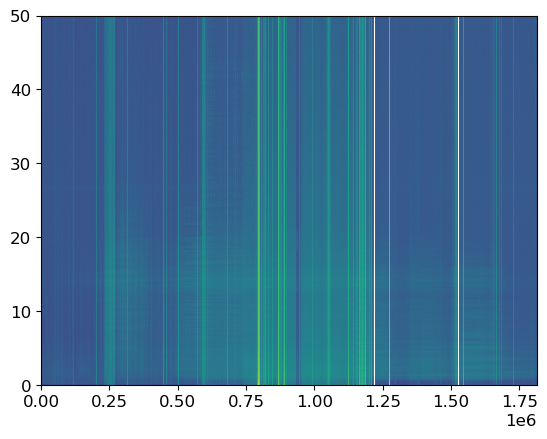

In [7]:
# frequenc filter
#fmin = 19
#fmax = 41
#st.filter('bandpass', freqmin=fmin, freqmax=fmax)
st = st.merge()
tr = st[0] #only get one obspy trace from obspy stream
s_date = tr.stats.starttime.date
e_date = tr.stats.endtime.date
data = tr.data #extract numpy data array from obspy trace

data = data/1. #extract numpy data array from obspy trace and convert to float   
# if len(loc) !=0:  
#     index = stn+'.'+loc
# else:
#     index = stn

# convert data from counts to velocity
# data = data / df_sens.loc[index][0] #V/(m/s) sensitivity
# data = data / df_sens.loc[index][1] #cnts/V

fs = tr.stats.sampling_rate #sampling rate

NFFT = fs * 600 #bin size for fourier transform. Type in length in seconds [for a day 100, for an hour 10]

#plot spectrogram on first axis
Pxx, freqs, bins, _ = plt.specgram(data, NFFT=int(NFFT), Fs=fs, 
                                    noverlap=fs*0, #overlap of bins in samples
                                    detrend='linear', #detrending before taking fourier transform
                                    mode='psd', #'psd', 'magnitude', 'angle', 'phase'
                                    scale_by_freq=True #unit/Hz
                                   )

In [5]:
# time resampling
from scipy.interpolate import interp1d
t_bins = [(tr.stats.starttime+i).timestamp for i in bins]

# !!! set time resolution here !!!
dt = 60*60 # in seconds
t_bins_out = np.arange(t_bins[0], t_bins[-1], dt)
# determine datagaps
nodatagap = np.all(~np.isnan(Pxx), axis=0)
f_restime = interp1d(np.array(t_bins)[nodatagap], Pxx[:,nodatagap], axis=1)
Pxx_res1 = f_restime(t_bins_out) 

# frequency resampling
# !!! set frequency resolution here !!!
df = 0.01 #Hz
freqs_out = np.arange(freqs[0], freqs[-1], df)
f_resfreq = interp1d(freqs, Pxx_res1, axis=0)
Pxx_res2 = f_resfreq(freqs_out) 

/tmp/ipykernel_1643858/161993402.py:18: RuntimeWarning: divide by zero encountered in log10
  im = ax1.imshow(10*np.log10(Pxx_res2), aspect='auto', origin='lower', cmap="inferno_r",


NameError: name 'h_int' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


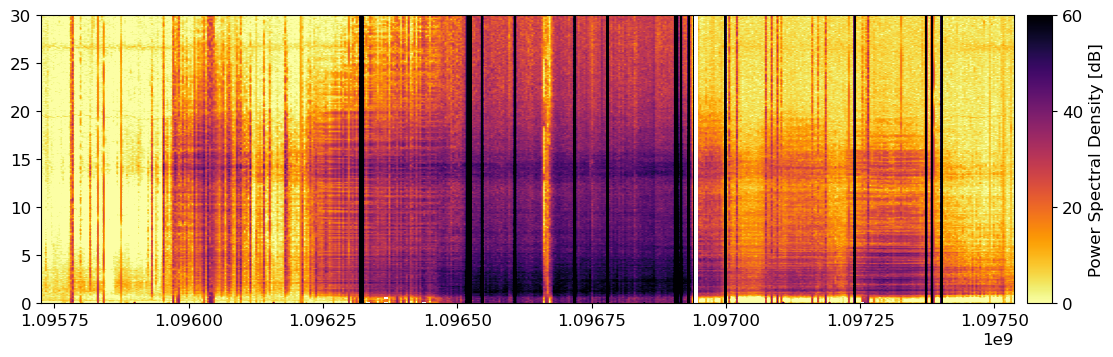

In [6]:
# plot
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['font.sans-serif'] = ['Verdana']

fig = plt.figure(figsize=(6.4*2,4.8))
ax1 = fig.add_axes([0.125, 0.125, 0.76, 0.6])
ax_cbar = fig.add_axes([0.895, 0.125, 0.02, 0.6]) # colorbar


im = ax1.imshow(10*np.log10(Pxx_res2), aspect='auto', origin='lower', cmap="inferno_r",
            extent=[t_bins_out[0], t_bins_out[-1],0,np.max(freqs_out)],
#            vmax=np.percentile(10*np.log10(Pxx_res2),99.9),
#            vmin=np.percentile(10*np.log10(Pxx_res2),1)
            vmax=60, vmin=0
                 )

cbar = plt.colorbar(im, cax=ax_cbar)
cbar.ax.locator_params(nbins=5)
cbar.set_label('Power Spectral Density [dB]', fontsize=12) #colorbar label

# ax1.set_yscale('log')
# ax1.set_ylim(0.1,np.max(freqs_out))
ax1.set_ylim(0,30)

# ===== x axes =====
stime = UTCDateTime(t_bins_out[0]).datetime
etime = UTCDateTime(t_bins_out[-2]).datetime

n_ticks = 8 # 8 x-ticks
h_ticks = 24 * np.round((etime-stime).days/8)
# h_int = 24*3 #24h * 3d
daterange = pd.date_range(stime, etime, freq=str(h_int)+'h', normalize=True)
# x_ticks_str = [t.strftime('%-d %b %-Hh') for t in x_ticks_timestamps]
x_ticks_str = [t.strftime('%-d %b') for t in daterange]
x_tickloc = [UTCDateTime(t).timestamp for t in daterange]
ax1.set_xticks(x_tickloc)
ax1.set_xticklabels(x_ticks_str)
ax1.set_xlim(t_bins_out[0], t_bins_out[-1])

ax1.set_xlabel('Date in {}'.format(tr.stats.starttime.year))
ax1.set_ylabel('Frequency [Hz]')

# ===== save figure =====
save_path = 'spectrogram/{}/{}/multiday/'.format(year,sta) # path where to save file
save_filename = '{}_{}_{}_{}.png'.format(year, str(jdays[0]).zfill(3), str(jdays[-2]).zfill(3), sta) # file name

if not os.path.exists(save_path): # create folders from save_path if not exists
    os.makedirs(save_path)

fig.savefig(save_path+save_filename, dpi=300, bbox_inches='tight')

# TESTS: can be deleted

In [128]:
mal_sehen = np.load('{}/{}.npy'.format(save_path, save_filename), allow_pickle=True)
mal_sehen.shape

(3,)

In [116]:
test_npa = np.array([Pxx, freqs, xx_arr])
test_npa.shape

/tmp/ipykernel_2239185/2093250994.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_npa = np.array([Pxx, freqs, xx_arr])


(3,)

In [117]:
test_npa

array([array([2.80785765e+15, 1.44348142e+15, 1.86116952e+13, 7.74299178e+12,
              3.51825130e+12, 2.28986406e+12, 1.59439052e+12, 1.14936004e+12,
              8.82180402e+11, 6.87423797e+11, 5.60865238e+11, 4.63249436e+11,
              3.84462711e+11, 3.31741647e+11, 2.85962214e+11, 2.47301493e+11,
              2.19474310e+11, 1.94280859e+11, 1.72814660e+11, 1.55928933e+11,
              1.40762375e+11, 1.27891710e+11, 1.16807441e+11, 1.07044175e+11,
              9.87174404e+10, 9.10051931e+10, 8.43366592e+10, 7.85843069e+10,
              7.30708570e+10, 6.83400901e+10, 6.41705687e+10, 6.01601144e+10,
              5.66696549e+10, 5.35032155e+10, 5.05208375e+10, 4.78561343e+10,
              4.53855335e+10, 4.31326107e+10, 4.10551829e+10, 3.90993491e+10,
              3.73543291e+10, 3.56966413e+10, 3.41269972e+10, 3.27342888e+10,
              3.13926948e+10, 3.01286291e+10, 2.89921025e+10, 2.78973183e+10,
              2.68719349e+10, 2.59224711e+10, 2.50179298e+10, 2.

In [115]:
xx_arr = np.array([1,3,5,7])
xx_arr

array([1, 3, 5, 7])

In [106]:
Pxx, freqs = matplotlib.mlab.psd(st[0].data, NFFT=16**2, Fs=st[0].stats.sampling_rate)
print(Pxx, freqs, NFFT)

[2.80785765e+15 1.44348142e+15 1.86116952e+13 7.74299178e+12
 3.51825130e+12 2.28986406e+12 1.59439052e+12 1.14936004e+12
 8.82180402e+11 6.87423797e+11 5.60865238e+11 4.63249436e+11
 3.84462711e+11 3.31741647e+11 2.85962214e+11 2.47301493e+11
 2.19474310e+11 1.94280859e+11 1.72814660e+11 1.55928933e+11
 1.40762375e+11 1.27891710e+11 1.16807441e+11 1.07044175e+11
 9.87174404e+10 9.10051931e+10 8.43366592e+10 7.85843069e+10
 7.30708570e+10 6.83400901e+10 6.41705687e+10 6.01601144e+10
 5.66696549e+10 5.35032155e+10 5.05208375e+10 4.78561343e+10
 4.53855335e+10 4.31326107e+10 4.10551829e+10 3.90993491e+10
 3.73543291e+10 3.56966413e+10 3.41269972e+10 3.27342888e+10
 3.13926948e+10 3.01286291e+10 2.89921025e+10 2.78973183e+10
 2.68719349e+10 2.59224711e+10 2.50179298e+10 2.41754918e+10
 2.33720209e+10 2.26199513e+10 2.19206752e+10 2.12388808e+10
 2.06079829e+10 2.00173758e+10 1.94369108e+10 1.89010339e+10
 1.83948003e+10 1.79020093e+10 1.74435904e+10 1.70060968e+10
 1.65876444e+10 1.619144

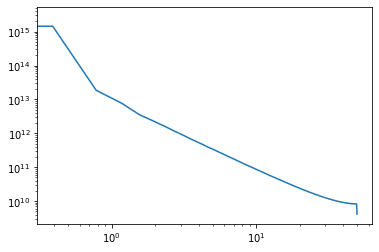

In [107]:
fig, ax = plt.subplots()
ax.plot(freqs, Pxx)
ax.set_xscale('log')
ax.set_yscale('log')